<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VQA_VQE(H2_Molecular_Optimized)_mkbahk_20251215.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
!pip install qiskit[visualization]==1.2.4
!pip install qiskit-aer==0.15.1
!pip install qiskit-algorithms==0.3.1
!pip install qiskit-nature[pyscf]==0.7.2
!pip install pyscf==2.6.0
!pip install py3Dmol

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import datetime
import time

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP

from qiskit.primitives import Estimator

In [5]:
# 1. PySCFDriver 설정 (STO-3G basis, 실험적 geometry)
driver = PySCFDriver(
    atom="H 0.0 0.0 0.0; H 0.0 0.0 0.74",
    #atom="O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0",
    basis="sto3g",
    charge=0,
    spin=0
)
problem = driver.run()  # ElectronicStructureProblem 생성

In [6]:
# 2. Mapper 설정 (ParityMapper + 2-qubit reduction)
mapper = ParityMapper(num_particles=problem.num_particles)

In [7]:
# 3. Ansatz 설정 (UCCSD + HartreeFock initial state)
initial_state = HartreeFock(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    qubit_mapper=mapper
)
ansatz = UCCSD(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    qubit_mapper=mapper,
    initial_state=initial_state
)

In [8]:
#ansatz.decompose().draw("mpl")
ansatz.decompose().draw()

┌───┐┌────────────────────┐┌────────────────────┐»
q_0: ┤ X ├┤0                   ├┤0                   ├»
     └───┘│  exp(-it IY)(t[0]) ││  exp(-it YI)(t[1]) │»
q_1: ─────┤1                   ├┤1                   ├»
          └────────────────────┘└────────────────────┘»
«     ┌───────────────────────────┐
«q_0: ┤0                          ├
«     │  exp(-it (XY + YX))(t[2]) │
«q_1: ┤1                          ├
«     └───────────────────────────┘

In [9]:
# 현재 시간 보관 (시작 시간)
start_time = datetime.datetime.now()

# 현재 시작 시간 표시
print(f"루틴 시작 시간: {start_time.strftime('%H시 %M분 %S초')}")

# 초기 파라미터 설정
initial_point = np.random.random(ansatz.num_parameters)

#수렴과정을 그래프로 그리기 위해 중간 상태 보관
cost_history = []
def store_intermediate_result(eval_count, parameters, mean, std):
  # 루틴 종료 시간
  end_time = datetime.datetime.now()
  # 시작 시간과 종료 시간의 차이 계산
  time_diff = end_time - start_time

  # 시:분:초로 표시
  total_seconds = int(time_diff.total_seconds())
  hours = total_seconds // 3600
  minutes = (total_seconds % 3600) // 60
  seconds = total_seconds % 60

  #print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  print(eval_count," 단계: ", mean, f"\t\t총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  cost_history.append(mean)
###def


루틴 시작 시간: 23시 46분 45초


In [10]:
# 4. Optimizer와 VQE 설정
optimizer = SLSQP(maxiter=1000)  # 충분한 iteration으로 수렴 보장
estimator = Estimator()  # Noiseless simulator primitive
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    callback=store_intermediate_result
)


In [11]:
# 5. GroundStateEigensolver로 실행
solver = GroundStateEigensolver(qubit_mapper=mapper, solver=vqe)

result = solver.solve(problem)

print("최적화 완료!!!")

# 루틴 종료 시간
end_time = datetime.datetime.now()
print(f"루틴 종료 시간: {end_time.strftime('%H시 %M분 %S초')}")

# 시작 시간과 종료 시간의 차이 계산
time_diff = end_time - start_time

# 시:분:초로 표시
total_seconds = int(time_diff.total_seconds())
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")


1  단계:  -0.8209947583637789 		총 실행 시간: 00시 00분 00초
2  단계:  -0.8209947499366403 		총 실행 시간: 00시 00분 00초
3  단계:  -0.820994745721948 		총 실행 시간: 00시 00분 00초
4  단계:  -0.8209947478557161 		총 실행 시간: 00시 00분 00초
5  단계:  -1.4573117834152403 		총 실행 시간: 00시 00분 00초
6  단계:  -1.4573117766686114 		총 실행 시간: 00시 00분 00초
7  단계:  -1.4573117901071742 		총 실행 시간: 00시 00분 00초
8  단계:  -1.4573118008520076 		총 실행 시간: 00시 00분 00초
9  단계:  -1.770622678743075 		총 실행 시간: 00시 00분 00초
10  단계:  -1.7706226839187738 		총 실행 시간: 00시 00분 00초
11  단계:  -1.7706226846345345 		총 실행 시간: 00시 00분 00초
12  단계:  -1.7706226730561847 		총 실행 시간: 00시 00분 00초
13  단계:  -1.7878574552052504 		총 실행 시간: 00시 00분 00초
14  단계:  -1.8478814168028461 		총 실행 시간: 00시 00분 00초
15  단계:  -1.8478814164652078 		총 실행 시간: 00시 00분 00초
16  단계:  -1.8478814162747728 		총 실행 시간: 00시 00분 00초
17  단계:  -1.8478814143810514 		총 실행 시간: 00시 00분 00초
18  단계:  -1.8493170479365901 		총 실행 시간: 00시 00분 00초
19  단계:  -1.852049680946133 		총 실행 시간: 00시 00분 00초
20  단계:  -1.852049681297

In [13]:
# 결과 출력
print("Total ground state energy (Hartree):", result.total_energies[0])
print("Nuclear repulsion energy:", result.nuclear_repulsion_energy)
print("Electronic ground state energy:", result.electronic_energies[0])
print("\nFull result:")
print(result)

Total ground state energy (Hartree): -1.137283800792749
Nuclear repulsion energy: 0.7151043390810812
Electronic ground state energy: -1.8523881398738302

Full result:
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.852388139874
  - computed part:      -1.852388139874
~ Nuclear repulsion energy (Hartree): 0.715104339081
> Total ground state energy (Hartree): -1.137283800793
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39839733]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.397982500886]
    - computed part:      [0.0  0.0  1.397982500886]
  > Dipole moment (a.u.): [0.0  0.0  0.000414829114]  Total: 0.000414829114
                 (debye): [0.0  0.0  0.001054390338]  Total: 0.001054390338
 


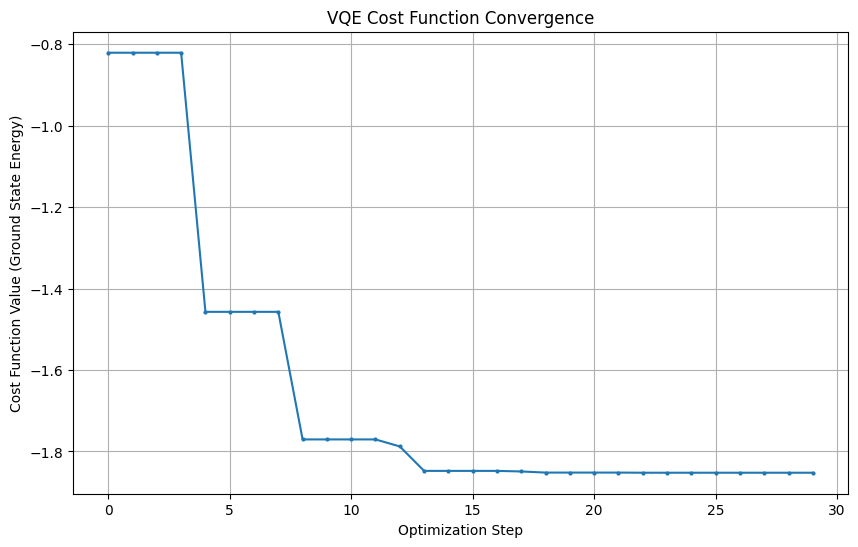

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', linestyle='-', markersize=2)
plt.title('VQE Cost Function Convergence')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Function Value (Ground State Energy)')
plt.grid(True)
plt.show()

# **D-Wave의 핵심 타겟은 quadratic binary/spin 모델이며, quadratic fermionic Hamiltonians와 Slater determinants는 gate-based 접근이 주를 이룹니다.**

In [16]:
import numpy as np
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian

# create Hamiltonian
hermitian_part = np.array(
    [
        [1.0, 2.0, 0.0, 0.0],
        [2.0, 1.0, 2.0, 0.0],
        [0.0, 2.0, 1.0, 2.0],
        [0.0, 0.0, 2.0, 1.0],
    ]
)
antisymmetric_part = np.array(
    [
        [0.0, 3.0, 0.0, 0.0],
        [-3.0, 0.0, 3.0, 0.0],
        [0.0, -3.0, 0.0, 3.0],
        [0.0, 0.0, -3.0, 0.0],
    ]
)
constant = 4.0

hamiltonian = QuadraticHamiltonian(
    hermitian_part=hermitian_part,
    antisymmetric_part=antisymmetric_part,
    constant=constant,
)

# convert it to a FermionicOp and print it
hamiltonian_ferm = hamiltonian.second_q_op()
print(hamiltonian_ferm)

Fermionic Operator
number spin orbitals=4, number terms=23
  4.0
+ 1.0 * ( +_0 -_0 )
+ 2.0 * ( +_0 -_1 )
+ 2.0 * ( +_1 -_0 )
+ 1.0 * ( +_1 -_1 )
+ 2.0 * ( +_1 -_2 )
+ 2.0 * ( +_2 -_1 )
+ 1.0 * ( +_2 -_2 )
+ 2.0 * ( +_2 -_3 )
+ 2.0 * ( +_3 -_2 )
+ 1.0 * ( +_3 -_3 )
+ 1.5 * ( +_0 +_1 )
+ -1.5 * ( +_1 +_0 )
+ 1.5 * ( +_1 +_2 )
+ -1.5 * ( +_2 +_1 )
+ 1.5 * ( +_2 +_3 )
+ -1.5 * ( +_3 +_2 )
+ -1.5 * ( -_0 -_1 )
+ 1.5 * ( -_1 -_0 )
+ -1.5 * ( -_1 -_2 )
+ 1.5 * ( -_2 -_1 )
+ -1.5 * ( -_2 -_3 )
+ 1.5 * ( -_3 -_2 )


In [17]:
# get the transformation matrix W and orbital energies {epsilon_j}
(
    transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()

print(f"Shape of matrix W: {transformation_matrix.shape}")
print(f"Orbital energies: {orbital_energies}")
print(f"Transformed constant: {transformed_constant}")

Shape of matrix W: (4, 8)
Orbital energies: [0.29826763 4.38883678 5.5513683  5.64193745]
Transformed constant: -1.9402050758492795


Eigenvalue: 3.909430851761581


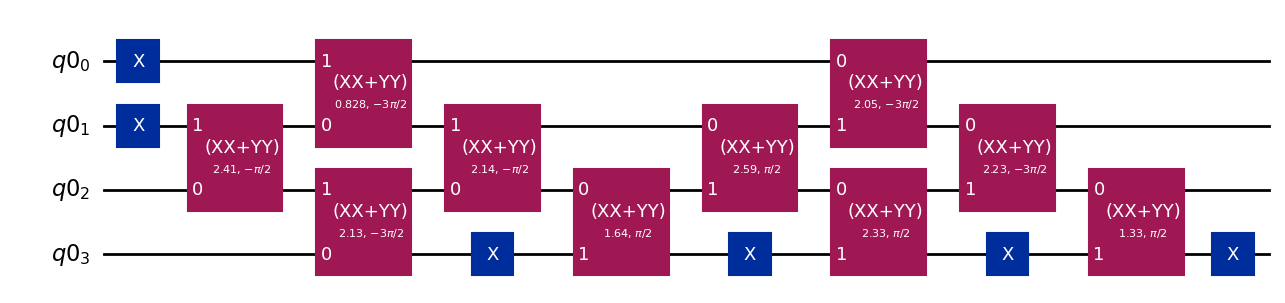

In [18]:
from qiskit_nature.second_q.circuit.library import FermionicGaussianState

occupied_orbitals = (0, 2)
eig = np.sum(orbital_energies[list(occupied_orbitals)]) + transformed_constant
print(f"Eigenvalue: {eig}")

circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals=occupied_orbitals)
circuit.draw("mpl")

In [19]:
from qiskit.quantum_info import Statevector
from qiskit_nature.second_q.mappers import JordanWignerMapper

# simulate the circuit to get the final state
state = np.array(Statevector(circuit))

# convert the Hamiltonian to a matrix
hamiltonian_jw = JordanWignerMapper().map(hamiltonian_ferm).to_matrix()

# check that the state is an eigenvector with the expected eigenvalue
np.testing.assert_allclose(hamiltonian_jw @ state, eig * state, atol=1e-8)

# **Slater determinants**

In [20]:
# create Hamiltonian
hermitian_part = np.array(
    [
        [1.0, 2.0, 0.0, 0.0],
        [2.0, 1.0, 2.0, 0.0],
        [0.0, 2.0, 1.0, 2.0],
        [0.0, 0.0, 2.0, 1.0],
    ]
)
constant = 4.0

hamiltonian = QuadraticHamiltonian(
    hermitian_part=hermitian_part,
    constant=constant,
)

print(f"Hamiltonian conserves particle number: {hamiltonian.conserves_particle_number()}")

Hamiltonian conserves particle number: True


In [21]:
# get the transformation matrix W and orbital energies {epsilon_j}
(
    transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()

print(f"Shape of matrix W: {transformation_matrix.shape}")
print(f"Orbital energies: {orbital_energies}")
print(f"Transformed constant: {transformed_constant}")

Shape of matrix W: (4, 4)
Orbital energies: [-2.23606798 -0.23606798  2.23606798  4.23606798]
Transformed constant: array(4.)


Eigenvalue: 4.000000000000001


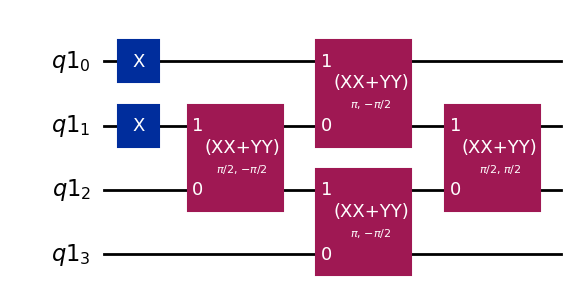

In [22]:
from qiskit_nature.second_q.circuit.library import SlaterDeterminant

occupied_orbitals = (0, 2)
eig = np.sum(orbital_energies[list(occupied_orbitals)]) + transformed_constant
print(f"Eigenvalue: {eig}")

circuit = SlaterDeterminant(transformation_matrix[list(occupied_orbitals)])
circuit.draw("mpl")

In [23]:
from qiskit_nature.second_q.circuit.library import BogoliubovTransform
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import random_hermitian, random_statevector, state_fidelity
from scipy.linalg import expm

# create Hamiltonian
n_modes = 5
hermitian_part = np.array(random_hermitian(n_modes))
hamiltonian = QuadraticHamiltonian(hermitian_part=hermitian_part)

# diagonalize Hamiltonian
(
    transformation_matrix,
    orbital_energies,
    _,
) = hamiltonian.diagonalizing_bogoliubov_transform()

# set simulation time and construct time evolution circuit
time = 1.0
register = QuantumRegister(n_modes)
circuit = QuantumCircuit(register)
bog_circuit = BogoliubovTransform(transformation_matrix)
# change to the diagonal basis of the Hamiltonian
circuit.append(bog_circuit.inverse(), register)
# perform time evolution by applying z rotations
for q, energy in zip(register, orbital_energies):
    circuit.rz(-energy * time, q)
###for

# change back to the original basis
circuit.append(bog_circuit, register)

# simulate the circuit
initial_state = random_statevector(2**n_modes)
final_state = initial_state.evolve(circuit)

# compute the correct state by direct exponentiation
hamiltonian_jw = JordanWignerMapper().map(hamiltonian.second_q_op()).to_matrix()
exact_evolution_op = expm(-1j * time * hamiltonian_jw)
expected_state = exact_evolution_op @ np.array(initial_state)

# check that the simulated state is correct
fidelity = state_fidelity(final_state, expected_state)
np.testing.assert_allclose(fidelity, 1.0, atol=1e-8)

# **Binding Energy between proton and neutron in the Deuteron nucleus**

**데우테론 결합 에너지는핵물리의 가장 기본적인 '테스트베드'로, 강한 상호작용의 본질을 이해하고 핵융합·천체물리 등 실용 분야로 연결되는 핵심 문제입니다.**

Step 1: Importing the packages that we need to tackle the problem

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.observables_evaluator import estimate_observables
from qiskit_algorithms.optimizers import COBYLA, SLSQP
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper

Step 2: Defining some functions that we will use

In [25]:
def kronecker_delta_function(n: int, m: int) -> int:
    """An implementation of the Kronecker delta function.

    Args:
        n (int): The first integer argument.
        m (int): The second integer argument.

    Returns:
        Returns 1 if n = m, else returns 0.
    """
    return int(n == m)
###def

In [27]:
def create_deuteron_hamiltonian(
    N: int, hbar_omega: float = 7.0, V_0: float = -5.68658111
) -> SparsePauliOp:
    """Creates a version of the Deuteron Hamiltonian as a qubit operator.

    Args:
        N (int): An integer number that represents the dimension of the
            basis.
        hbar_omega (float, optional): The value of the product of hbar and omega. Defaults to 7.0.
        V_0 (float, optional): The value of the potential energy. Defaults to -5.68658111.

    Returns:
        SparsePauliOp: The qubit-space Hamiltonian that represents the Deuteron.
    """
    hamiltonian_terms = {}
    for m in range(N):
        for n in range(N):
            label = "+_{} -_{}".format(str(n), str(m))
            coefficient_kinect = (hbar_omega / 2) * (
                (2 * n + 3 / 2) * kronecker_delta_function(n, m)
                - np.sqrt(n * (n + (1 / 2))) * kronecker_delta_function(n, m + 1)
                - np.sqrt((n + 1) * (n + (3 / 2)) * kronecker_delta_function(n, m - 1))
            )
            hamiltonian_terms[label] = coefficient_kinect

            coefficient_potential = (
                V_0 * kronecker_delta_function(n, 0) * kronecker_delta_function(n, m)
            )
            hamiltonian_terms[label] += coefficient_potential
        ###for
    ###for

    hamiltonian = FermionicOp(hamiltonian_terms, num_spin_orbitals=N)
    mapper = JordanWignerMapper()
    qubit_hamiltonian = mapper.map(hamiltonian)
    if not isinstance(qubit_hamiltonian, SparsePauliOp):
        qubit_hamiltonian = qubit_hamiltonian.primitive
    ###if

    return qubit_hamiltonian
###def

Step 3: Using Qiskit tools to calculate the binding energy between proton and neutron in Deuteron nucleus

In [28]:
deuteron_hamiltonians = [create_deuteron_hamiltonian(i) for i in range(1, 5)]

In [29]:
for i, hamiltonian in enumerate(deuteron_hamiltonians):
    print("Deuteron Hamiltonian: H_{}".format(i + 1))
    print(hamiltonian)
    print("\n")
###for

Deuteron Hamiltonian: H_1
SparsePauliOp(['I', 'Z'],
              coeffs=[-0.21829055+0.j,  0.21829055+0.j])


Deuteron Hamiltonian: H_2
SparsePauliOp(['II', 'IZ', 'XX', 'YY', 'ZI'],
              coeffs=[ 5.90670945+0.j,  0.21829055+0.j, -2.14330352+0.j, -2.14330352+0.j,
 -6.125     +0.j])


Deuteron Hamiltonian: H_3
SparsePauliOp(['III', 'IIZ', 'IXX', 'IYY', 'IZI', 'XXI', 'YYI', 'ZII'],
              coeffs=[15.53170945+0.j,  0.21829055+0.j, -2.14330352+0.j, -2.14330352+0.j,
 -6.125     +0.j, -3.91311896+0.j, -3.91311896+0.j, -9.625     +0.j])


Deuteron Hamiltonian: H_4
SparsePauliOp(['IIII', 'IIIZ', 'IIXX', 'IIYY', 'IIZI', 'IXXI', 'IYYI', 'IZII', 'XXII', 'YYII', 'ZIII'],
              coeffs=[ 28.65670945+0.j,   0.21829055+0.j,  -2.14330352+0.j,  -2.14330352+0.j,
  -6.125     +0.j,  -3.91311896+0.j,  -3.91311896+0.j,  -9.625     +0.j,
  -5.67064811+0.j,  -5.67064811+0.j, -13.125     +0.j])




In [30]:
theta = Parameter(r"$\theta$")
eta = Parameter(r"$\eta$")

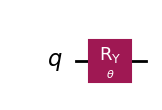

In [31]:
wavefunction = QuantumCircuit(1)
wavefunction.ry(theta, 0)
wavefunction.draw("mpl")

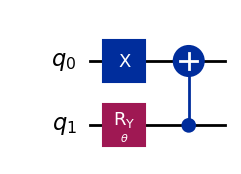

In [32]:
wavefunction2 = QuantumCircuit(2)
wavefunction2.x(0)
wavefunction2.ry(theta, 1)
wavefunction2.cx(1, 0)
wavefunction2.draw("mpl")

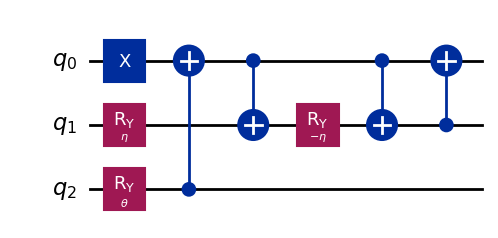

In [33]:
wavefunction3 = QuantumCircuit(3)
wavefunction3.x(0)
wavefunction3.ry(eta, 1)
wavefunction3.ry(theta, 2)
wavefunction3.cx(2, 0)
wavefunction3.cx(0, 1)
wavefunction3.ry(-eta, 1)
wavefunction3.cx(0, 1)
wavefunction3.cx(1, 0)
wavefunction3.draw("mpl")

In [34]:
ansatz = [wavefunction, wavefunction2, wavefunction3]

In [35]:
reference_values = []
print("Exact binding energies calculated through numpy.linalg.eigh \n")
for i, hamiltonian in enumerate(deuteron_hamiltonians):
    eigenvalues, eigenstates = np.linalg.eigh(hamiltonian.to_matrix())
    reference_values.append(eigenvalues[0])
    print("Exact binding energy for H_{}: {}".format(i + 1, eigenvalues[0]))
###for

Exact binding energies calculated through numpy.linalg.eigh 

Exact binding energy for H_1: -0.43658110999999966
Exact binding energy for H_2: -1.7491598763215301
Exact binding energy for H_3: -2.045670898406441
Exact binding energy for H_4: -2.143981030799862


In [36]:
print(
    "Results using Estimator for H_1, H_2 and H_3 with the ansatz given in the reference paper \n"
)

for i in range(3):
    seed = 42
    algorithm_globals.random_seed = seed
    vqe = VQE(Estimator(), ansatz=ansatz[i], optimizer=SLSQP())
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}: {} MeV".format(i + 1, binding_energy))
###for

Results using Estimator for H_1, H_2 and H_3 with the ansatz given in the reference paper 

Binding energy for H_1: -0.4365811096105766 MeV
Binding energy for H_2: -1.7491595316527717 MeV
Binding energy for H_3: -2.045670898257444 MeV


In [37]:
def callback(eval_count, parameters, mean, std):
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
###for

In [38]:
plots = []

for i in range(3):

    counts = []
    values = []
    params = []
    deviation = []
    seed = 42
    algorithm_globals.random_seed = seed
    vqe = VQE(Estimator(), ansatz=ansatz[i], optimizer=COBYLA(), callback=callback)
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots.append([counts, values])
###for

'Evaluation: 37, Energy: -2.045670781666786, Std: {}'

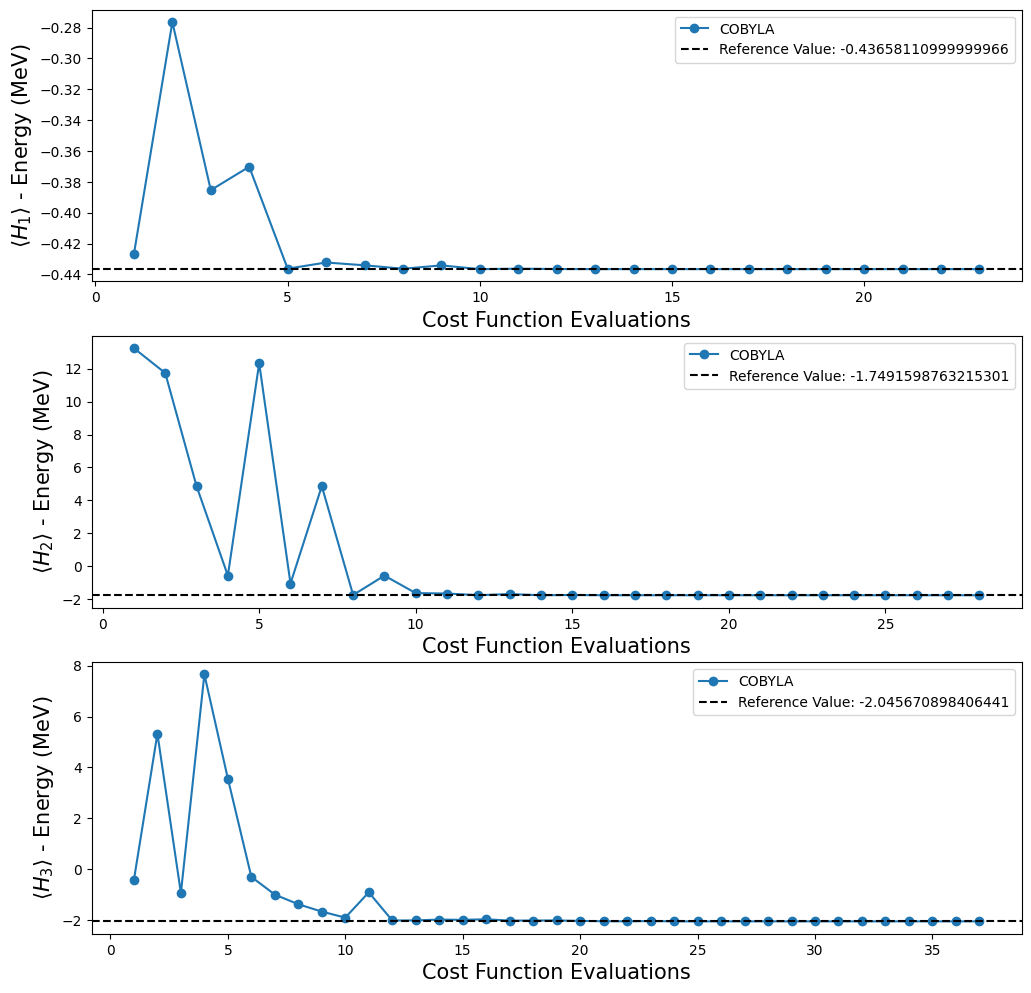

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches((12, 12))

for i, plot in enumerate(plots):
    ax[i].plot(plot[0], plot[1], "o-", label="COBYLA")
    ax[i].axhline(
        y=reference_values[i],
        color="k",
        linestyle="--",
        label=f"Reference Value: {reference_values[i]}",
    )
    ax[i].legend()
    ax[i].set_xlabel("Cost Function Evaluations", fontsize=15)
    ax[i].set_ylabel(r"$\langle H_{} \rangle$ - Energy (MeV)".format(i + 1), fontsize=15)
###for

plt.show()


In [40]:
twolocal_ansatzes = []
for i in range(1, 5):
    ansatz = TwoLocal(
        deuteron_hamiltonians[i - 1].num_qubits,
        ["rz", "ry"],
        "cx",
        entanglement="full",
        reps=i,
        initial_state=None,
    )
    twolocal_ansatzes.append(ansatz)
###for

In [41]:
print("Results using Estimator for H_1, H_2, H_3 and H_4 with TwoLocal ansatz \n")
seed = 42
algorithm_globals.random_seed = seed
for i in range(4):
    vqe = VQE(Estimator(), ansatz=twolocal_ansatzes[i], optimizer=SLSQP())
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}:".format(i + 1), binding_energy, "MeV")
###for

Results using Estimator for H_1, H_2, H_3 and H_4 with TwoLocal ansatz 

Binding energy for H_1: -0.4365806560079575 MeV
Binding energy for H_2: -1.7491598684314065 MeV
Binding energy for H_3: -2.0456703372248928 MeV
Binding energy for H_4: -2.1439196774338356 MeV


In [42]:
seed = 42
algorithm_globals.random_seed = seed

plots_tl = []
for i in range(4):

    counts = []
    values = []
    params = []
    deviation = []
    vqe = VQE(
        Estimator(),
        ansatz=twolocal_ansatzes[i],
        optimizer=SLSQP(),
        callback=callback,
    )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots_tl.append([counts, values])
###for

'Evaluation: 4190, Energy: -2.143919677411189, Std: {}'

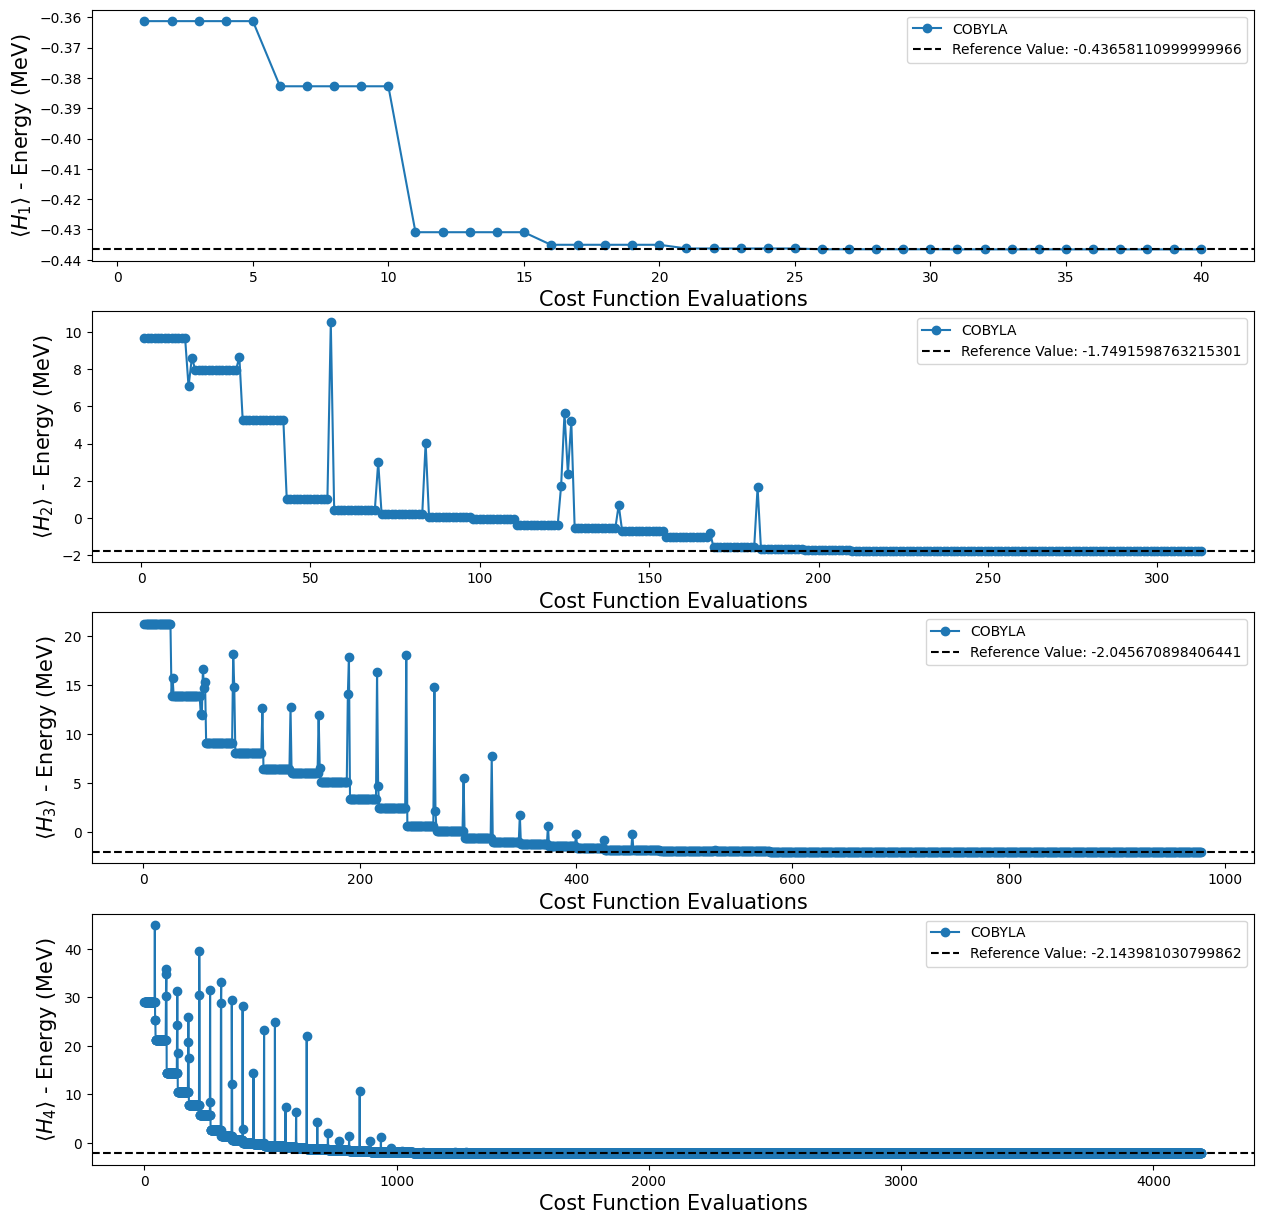

In [43]:
fig, ax = plt.subplots(nrows=4, ncols=1)
fig.set_size_inches((15, 15))

for i, plot in enumerate(plots_tl):
    ax[i].plot(plot[0], plot[1], "o-", label="COBYLA")
    ax[i].axhline(
        y=reference_values[i],
        color="k",
        linestyle="--",
        label=f"Reference Value: {reference_values[i]}",
    )
    ax[i].legend()
    ax[i].set_xlabel("Cost Function Evaluations", fontsize=15)
    ax[i].set_ylabel(r"$\langle H_{} \rangle$ - Energy (MeV)".format(i + 1), fontsize=15)
###for

plt.show()

Step 4: Calculating the observables expectation values

In [44]:
def calculate_observables_exp_values(
    quantum_circuit: QuantumCircuit, observables: list, angles: list
) -> list:
    """Calculate the expectation value of an observable given the quantum
    circuit that represents the wavefunction and a list of parameters.

        Args:
            quantum_circuit (QuantumCircuit): A parameterized quantum circuit
            that represents the wavefunction of the system.

            observables (list): A list containing the observables that we want
            to know the expectation values.

            angles (list): A list with the values that will be used in the
            'assign_parameters' method.

        Returns:
            list_exp_values (list): A list containing the expectation values
            of the observables given as input.
    """
    list_exp_values = []
    for observable in observables:
        exp_values = []
        for angle in angles:
            qc = quantum_circuit.assign_parameters({theta: angle})
            result = estimate_observables(
                Estimator(),
                quantum_state=qc,
                observables=[observable],
            )
            exp_values.append(result[0][0])
        ###for

        list_exp_values.append(exp_values)
    ###for

    return list_exp_values
###def

In [45]:
angles = list(np.linspace(-np.pi, np.pi, 100))
observables = [
    Pauli("IZ"),
    Pauli("ZI"),
    Pauli("XX"),
    Pauli("YY"),
    deuteron_hamiltonians[1],
]
h2_observables_exp_values = calculate_observables_exp_values(wavefunction2, observables, angles)

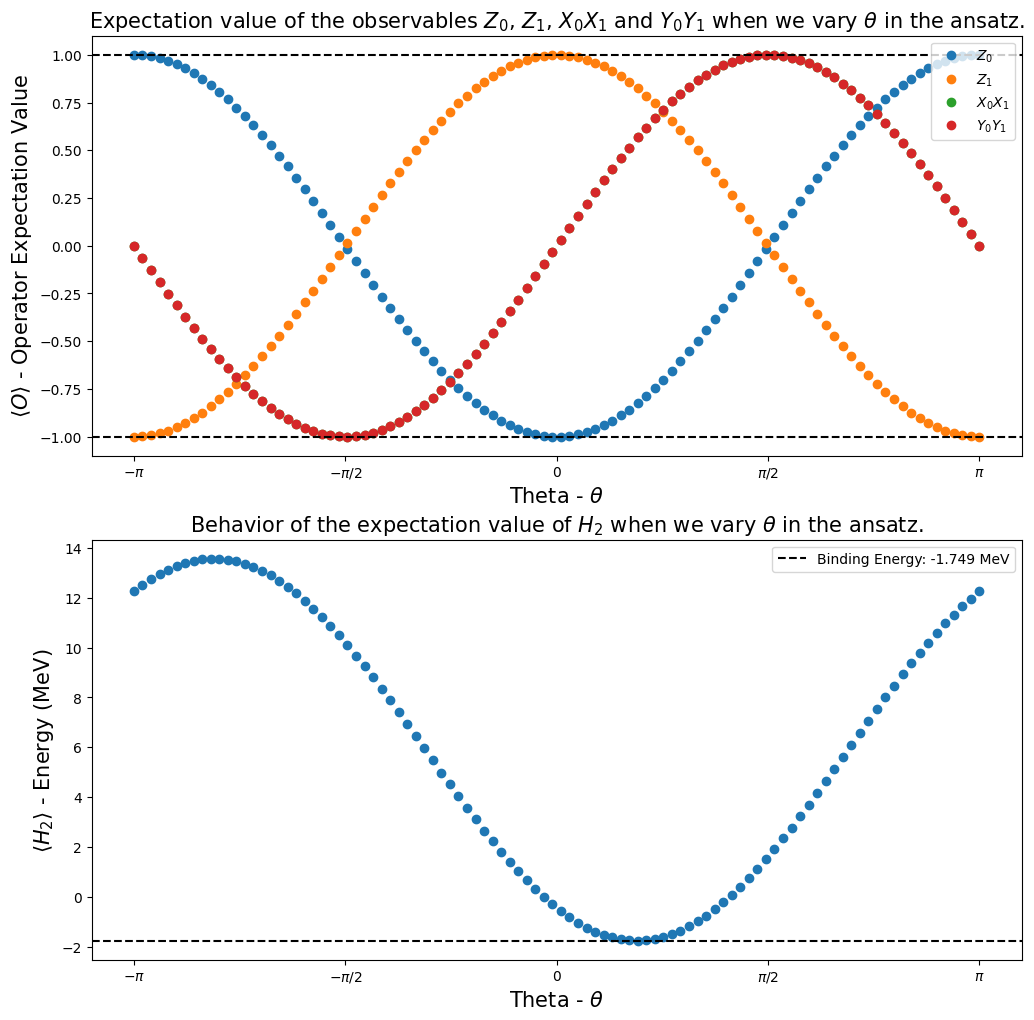

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches((12, 12))
ax[0].plot(angles, h2_observables_exp_values[0], "o", label=r"$Z_0$")
ax[0].plot(angles, h2_observables_exp_values[1], "o", label=r"$Z_1$")
ax[0].plot(angles, h2_observables_exp_values[2], "o", label=r"$X_0X_1$")
ax[0].plot(angles, h2_observables_exp_values[3], "o", label=r"$Y_0Y_1$")
ax[0].axhline(
    y=1,
    color="k",
    linestyle="--",
)
ax[0].axhline(y=-1, color="k", linestyle="--")
ax[0].legend()
ax[0].set_xlabel(r"Theta - $\theta$", fontsize=15)
ax[0].set_ylabel(r"$\langle O \rangle $ - Operator Expectation Value", fontsize=15)
ax[0].set_xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    labels=[r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"],
)
ax[0].set_title(
    r"Expectation value of the observables $Z_0$, $Z_1$, $X_0X_1$ and $Y_0Y_1$ when we vary $\theta$ in the ansatz.",
    fontsize=15,
)
ax[1].plot(angles, h2_observables_exp_values[4], "o")
ax[1].axhline(
    y=reference_values[1],
    color="k",
    linestyle="--",
    label="Binding Energy: {} MeV".format(np.round(reference_values[1], 3)),
)
ax[1].legend()
ax[1].set_xlabel(r"Theta - $\theta$", fontsize=15)
ax[1].set_ylabel(r"$\langle H_2 \rangle $ - Energy (MeV)", fontsize=15)
ax[1].set_xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    labels=[r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"],
)
ax[1].set_title(
    r"Behavior of the expectation value of $H_2$ when we vary $\theta$ in the ansatz.", fontsize=15
)

plt.show()